<a href="https://colab.research.google.com/github/GabrielReis2701/transfer-learning/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

Este tutorial o guiará pelo processo de uso do _transfer learning_ para aprender um classificador de imagem preciso a partir de um número relativamente pequeno de amostras de treinamento. De um modo geral, a aprendizagem de transferência refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como …tarefas (como de [ILSVRC](http://www.image-net.org/challenges/ LSVRC/)), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagem para aumentar o desempenho de seus próprios modelos específicos de tarefas.

#### Feature extraction vs. fine-tuning

Em um extremo, o aprendizado de transferência pode envolver pegar a rede pré-treinada e congelar os pesos, e usar uma de suas camadas ocultas (geralmente a última… -ajuste as camadas posteriores. Qual estratégia é a melhor depende do tamanho do seu conjunto de dados, do número de classes e de quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de recursos aprendidos ). Uma discussão mais detalhada sobre como criar estratégias pode ser encontrada em [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer -Aprendendo/).
## Procedure

Neste guia, passaremos pelo processo de carregamento de um classificador de imagem de 1000 classes de última geração, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) que [venceu o desafio ImageNet em 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), e usando-o como um extrator de recursos fixos para treinar um classificador personalizado menor em nossas próprias imagens, embora com muito pouco código alterações, você pode tentar ajustar também.

Primeiro vamos carregar o VGG16 e remover sua camada final, a camada de classificação softmax de 1000 classes específica para ImageNet, e substituí-la por uma nova camada de classificação para as classes sobre as quais estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos que se conectam à nova camada de classificação, e treinaremos a nova camada de classificação sobre nosso novo conjunto de dados.

Também compararemos esse método com o treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como nosso sujeito de teste, usaremos um conjunto de dados composto por cerca de 6.000 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão. Vale a pena notar que essa estratégia se adapta bem a conjuntos de imagens em que você pode ter apenas algumas centenas ou menos imagens. Seu desempenho será menor a partir de um pequeno número de amostras (dependendo das classes) como de costume, mas ainda impressionante considerando as restrições usuais.


In [114]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras import applications

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import np_utils

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000. 

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

In [115]:
!wget https://drive.google.com/file/d/1-VipCTi3-PQfjnmUmK_TKShEBCm2QvVo/view?usp=sharing
!wget https://drive.google.com/file/d/1uN5DbNhnfCb0SRzJW0n5WQm2VCOem808/view?usp=sharing
!7z x /content/insetos.zip
!7z x /content/imagensTeste.zip


--2022-08-20 19:17:27--  https://drive.google.com/file/d/1-VipCTi3-PQfjnmUmK_TKShEBCm2QvVo/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 172.217.219.102, 172.217.219.113, 172.217.219.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.219.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing.2’

view?usp=sharing.2      [ <=>                ]  66.17K  --.-KB/s    in 0.002s  

2022-08-20 19:17:27 (27.1 MB/s) - ‘view?usp=sharing.2’ saved [67760]

--2022-08-20 19:17:27--  https://drive.google.com/file/d/1uN5DbNhnfCb0SRzJW0n5WQm2VCOem808/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 172.217.219.102, 172.217.219.113, 172.217.219.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.219.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing.3’

view?usp=sharing.3      [ <=>  

In [116]:
root = 'insetos'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces','.ipynb_checkpoints']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['insetos/Joaninha', 'insetos/Aranha', 'insetos/Formiga']


 Esta função é útil para pré-processar os dados em uma imagem e vetor de entrada.

In [117]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [118]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize a ordem dos dados.

In [119]:
random.shuffle(data)

criar treinamento / validação / divisão de teste (70%, 15%, 15%)

In [120]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

 
Dados separados para rótulos.

In [121]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1]



Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [122]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(12, 3)


 
Vamos fazer um resumo do que temos.

In [123]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 80 images from 3 categories
train / validation / test split: 56, 12, 12
training data shape:  (56, 224, 224, 3)
training labels shape:  (56, 3)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido em três conjuntos: `train`, `val` e `test`. A forma dos dados de treinamento deve ser (`n`, 224, 224, 3) onde `n` é o tamanho do seu conjunto de treinamento e os rótulos devem ser (`n`, `c`) onde `c` é o número de classes (97 no caso de `101_ObjectCategories`.

Observe que dividimos todos os dados em três subconjuntos -- um conjunto de treinamento `train`, um conjunto de validação `val` e um conjunto de teste `test`. A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento. O conjunto `test` é sempre retirado do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vejamos rapidamente algumas imagens de amostra do nosso conjunto de dados.

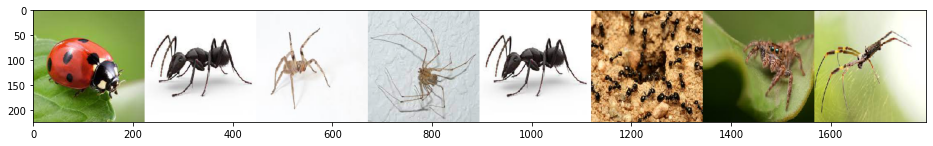

In [124]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Primeiro treinando uma rede neural do zero

Antes de fazer o aprendizado de transferência, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência mais tarde.

A rede que construiremos contém 4 camadas convolucionais e de pool máximo alternadas, seguidas por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada par conv/pooling . Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, perda categórica de entropia cruzada, e nosso algoritmo de aprendizado será [AdaDelta](https://arxiv.org/abs/1212.5701). Várias coisas sobre esta rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação e então não é necessário gastar muito tempo tentando otimizar esta rede.

 
Ao compilar a rede, vamos executar `model.summary()` para obter um instantâneo de suas camadas.

In [125]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_30 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_31 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles está levando para uma camada totalmente conectada pré-softmax 'dense_5'.

Agora podemos ir em frente e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo mais tarde.

In [126]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(x_val, y_val))


Epoch 1/200
1/1 [==============================] - 1s 813ms/step - loss: 1.1114 - accuracy: 0.2679 - val_loss: 1.0700 - val_accuracy: 0.5833
Epoch 2/200
1/1 [==============================] - 0s 128ms/step - loss: 1.0721 - accuracy: 0.4107 - val_loss: 1.0457 - val_accuracy: 0.3333
Epoch 3/200
1/1 [==============================] - 0s 116ms/step - loss: 1.0353 - accuracy: 0.3929 - val_loss: 1.0080 - val_accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 106ms/step - loss: 0.9939 - accuracy: 0.5179 - val_loss: 0.9669 - val_accuracy: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 108ms/step - loss: 0.9216 - accuracy: 0.5714 - val_loss: 0.9862 - val_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 99ms/step - loss: 0.9107 - accuracy: 0.5357 - val_loss: 0.9804 - val_accuracy: 0.4167
Epoch 7/200
1/1 [==============================] - 0s 102ms/step - loss: 0.8833 - accuracy: 0.6071 - val_loss: 1.0011 - val_accuracy: 0.3333
Epoch 8/200
1/


Vamos plotar a perda de validação e a precisão da validação ao longo do tempo.

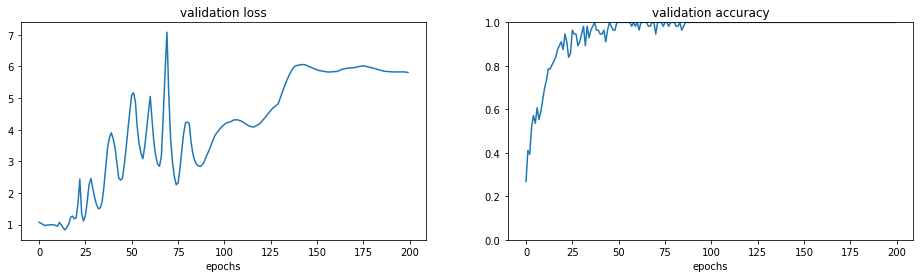

In [127]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a se ajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado cedo nessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente inferior.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [128]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.295031189918518
Test accuracy: 0.6666666865348816


Por fim, vemos que atingimos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6000 imagens, considerando que se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Transfira o aprendizado começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

Para começar, vamos carregar o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for sua primeira vez carregando o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede é carregada, podemos inspecionar novamente as camadas com o método `summary()`.

In [129]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Notice** que VGG16 é _muito_ maior que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma [taxa de erro dos 5 principais 8,8%](https://github.com/jcjohnson/cnn-benchmarks), o que significa que 91,2% das amostras de teste foram classificadas corretamente entre os 5 principais previsões para cada imagem. A precisão top 1 - equivalente à métrica de precisão que estamos usando (que a previsão principal está correta) - é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que suposições aleatórias nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, 'removemos' a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca 'removemos' nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe keras `Model` para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada `new_classification_layer`. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [130]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente esta rede, `model_new` no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e desvios em todas as camadas da rede, exceto nossa nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente melhor do que podemos treinar em nosso conjunto de dados limitado. 

Ao definir o sinalizador `trainable` em cada camada como false (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável *não* congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais das camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de recursos, temendo que o ajuste fino demais com esse conjunto de dados possa ser excessivo. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda que em nossa primeira rede, para uma comparação justa. Em seguida, executamos o `summary` novamente para observar a arquitetura da rede.

In [131]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos cerca de 134 milhões de pesos, mas agora a grande maioria deles são 'parâmetros não treináveis' porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto dos número de parâmetros necessários para treinar o primeiro modelo.

Como antes, vamos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também acompanhamos sua história à medida que avançamos.

In [132]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=200, 
                         validation_data=(x_val, y_val))


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1.6152 - accuracy: 0.3393 - val_loss: 1.2007 - val_accuracy: 0.4167
Epoch 2/200
1/1 [==============================] - 0s 366ms/step - loss: 1.6563 - accuracy: 0.3214 - val_loss: 0.8248 - val_accuracy: 0.5833
Epoch 3/200
1/1 [==============================] - 0s 366ms/step - loss: 1.7166 - accuracy: 0.3393 - val_loss: 0.9562 - val_accuracy: 0.5833
Epoch 4/200
1/1 [==============================] - 0s 366ms/step - loss: 1.5375 - accuracy: 0.3393 - val_loss: 1.0307 - val_accuracy: 0.5833
Epoch 5/200
1/1 [==============================] - 0s 369ms/step - loss: 1.0929 - accuracy: 0.3750 - val_loss: 1.5444 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 367ms/step - loss: 1.0987 - accuracy: 0.3750 - val_loss: 1.9277 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 364ms/step - loss: 1.2393 - accuracy: 0.3750 - val_loss: 1.9095 - val_accuracy: 0.0833
Epoch 8/

Nossa precisão de validação paira perto de 80% no final, o que é mais de 30% de melhoria na rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que esta rede realmente treina _ligeiramente mais rápido_ que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque o congelamento dos pesos nega a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda de validação e precisão novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

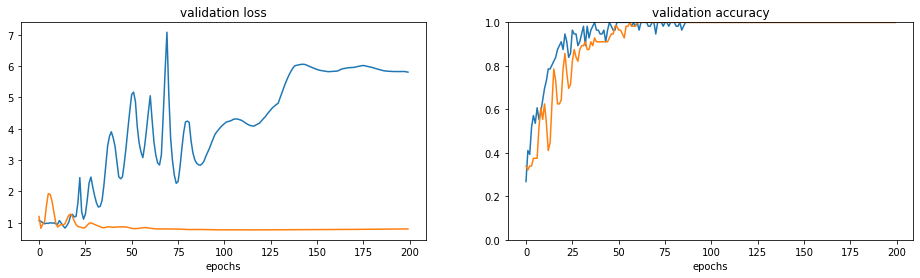

In [133]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.plot(history2.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a se ajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente melhoraria ligeiramente sua precisão com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente por 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais dropout, mas certamente não teríamos compensado a melhoria de 30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [134]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.36219310760498047
Test accuracy: 0.8333333134651184


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [164]:
img, x = get_image('/content/imagensTeste/1.jpg')
probabilities = model_new.predict([x])
print("    Joaninha        Aranha       Formiga")
print(probabilities)


    Joaninha        Aranha       Formiga
[[2.5060207e-10 1.0000000e+00 2.7655414e-08]]


### Improving the results

78.2% top-1 accuracy on 97 classes, roughly evenly distributed, is a pretty good achievement. It is not quite as impressive as the original VGG16 which achieved 73% top-1 accuracy on 1000 classes. Nevertheless, it is much better than what we were able to achieve with our original network, and there is room for improvement. Some techniques which possibly could have improved our performance.

- Using data augementation: augmentation refers to using various modifications of the original training data, in the form of distortions, rotations, rescalings, lighting changes, etc to increase the size of the training set and create more tolerance for such distortions.
- Using a different optimizer, adding more regularization/dropout, and other hyperparameters.
- Training for longer (of course)

A more advanced example of transfer learning in Keras, involving augmentation for a small 2-class dataset, can be found in the [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).